In [1]:
import sys
import time
import os
from collections import defaultdict
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map

vedo.settings.default_backend = "vtk"
# vedo.settings.renderer_frame_width = 1.
# vedo.settings.use_parallel_projection = True

import matplotlib.pyplot as plt

# from matplotlib import colormaps
# list(colormaps)
from matplotlib.colors import LinearSegmentedColormap

from ipywidgets import interact

from jax import jit, vmap, value_and_grad, nn
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft2, ifft2, fftshift, fftfreq
from jaxdf import FourierSeries
from jaxdf.operators import compose
from jwave.geometry import Domain, Medium, TimeAxis, circ_mask
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
import vis
import reconstruct as r
import generate_data as gd
import util as u
import reconstruct as r
from PADataset import PADataset
from flax import linen as nn

key = jax.random.PRNGKey(68002)


@u.timer
def reconstruct(func_recon, func_step, **kwargs):
    return func_recon(func_step=func_step, **kwargs)

# Visualize the current data and reconstruction

interactive(children=(IntSlider(value=356, description='file', max=499), IntSlider(value=9, description='it', …

Text(value='0.0')

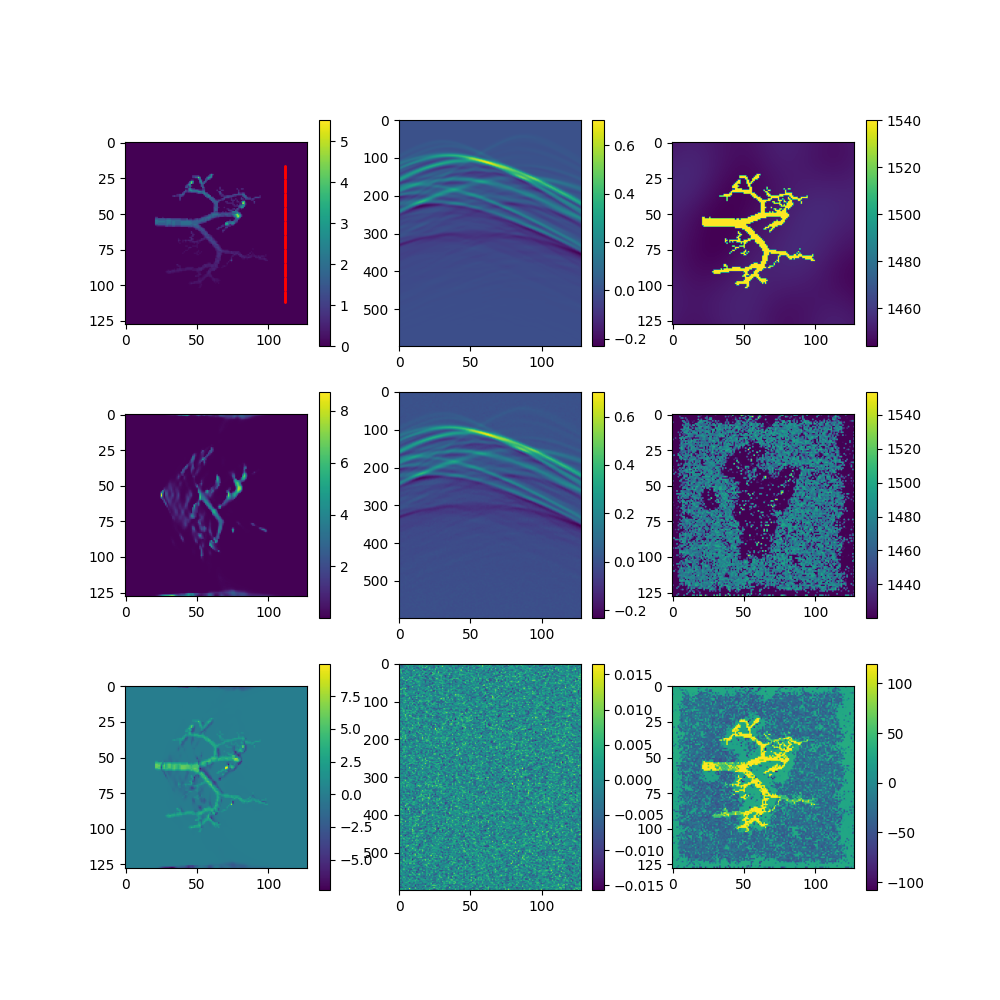

In [11]:
# Visualize data

%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import os

plt.close('all')

dataset = PADataset()

def load_data(idx, it):
    global max_file, max_it, mu, angles, P_0, c, P_data, P_data_noisy, sensors, mu_r, c_r, ATT_masks

    data = dataset[idx]
    data = dataset.load_recon(idx, it)
    mu = data['mu']
    angles = data['angles']
    P_0 = data['P_0']
    c = data['c']
    P_data = data['P_data']
    P_data_noisy = data['P_data_noisy']
    sensors = data['sensors']
    mu_r = data['mu_r']
    c_r = data['c_r']
    ATT_masks = data['ATT_masks']

    max_it = u.max_iteration()
    max_file = len(os.listdir(u.mu_path)) - 1

max_recon_file = 0
if os.path.exists(u.checkpoints_path):
    file_list = [int(os.path.splitext(os.path.basename(checkpoint_path))[0]) for checkpoint_path in os.listdir(u.checkpoints_path)]
    if len(file_list) > 0:
        max_recon_file = max(file_list)
    # max_recon_file = max(os.listdir(u.checkpoints_path))
load_data(max_recon_file, 0)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
# fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)

im0 = ax[0][0].imshow(P_0[0], aspect='equal')
sc0 = ax[0][0].scatter(sensors[1], sensors[0], c='r', s=1)
im1 = ax[0][1].imshow(P_data[0], aspect='auto')
im2 = ax[0][2].imshow(c, aspect='equal')
im3 = ax[1][0].imshow(mu_r, aspect='equal')
im4 = ax[1][1].imshow(P_data_noisy[0], aspect='auto')
im5 = ax[1][2].imshow(c_r, aspect='equal')
im6 = ax[2][0].imshow(P_0[0] - mu_r, aspect='equal')
im7 = ax[2][1].imshow(P_data[0] - P_data_noisy[0], aspect='auto')
im8 = ax[2][2].imshow(c - c_r, aspect='equal')
txt0 = widgets.Text(str(angles[0]))

cbar0 = fig.colorbar(im0, ax=ax[0][0])
cbar1 = fig.colorbar(im1, ax=ax[0][1])
cbar2 = fig.colorbar(im2, ax=ax[0][2])
cbar3 = fig.colorbar(im3, ax=ax[1][0])
cbar4 = fig.colorbar(im4, ax=ax[1][1])
cbar5 = fig.colorbar(im5, ax=ax[1][2])
cbar6 = fig.colorbar(im6, ax=ax[2][0])
cbar7 = fig.colorbar(im7, ax=ax[2][1])
cbar8 = fig.colorbar(im8, ax=ax[2][2])

def show_data(il):
    """
    il: illumination index
    """
    im0.set_array(P_0[il])
    im1.set_array(P_data[il])
    im2.set_array(c)
    im3.set_array(mu_r)
    im4.set_array(P_data_noisy[il])
    im5.set_array(c_r)
    im6.set_array(mu - mu_r)
    im7.set_array(P_data[il] - P_data_noisy[il])
    im8.set_array(c - c_r)
    
    # Update normalization
    im0.set_clim(vmin=P_0[il].min(), vmax=P_0[il].max())
    im1.set_clim(vmin=P_data[il].min(), vmax=P_data[il].max())
    im2.set_clim(vmin=c.min(), vmax=c.max())
    im3.set_clim(vmin=mu_r.min(), vmax=mu_r.max())
    im4.set_clim(vmin=P_data_noisy[il].min(), vmax=P_data_noisy[il].max())
    im5.set_clim(vmin=c_r.min(), vmax=c_r.max())
    im6.set_clim(vmin=(mu - mu_r).min(), vmax=(mu - mu_r).max())
    im7.set_clim(vmin=(P_data[il] - P_data_noisy[il]).min(), vmax=(P_data[il] - P_data_noisy[il]).max())
    im8.set_clim(vmin=(c - c_r).min(), vmax=(c - c_r).max())

    # Update colorbars
    cbar0.update_normal(im0)
    cbar1.update_normal(im1)
    cbar2.update_normal(im2)
    cbar3.update_normal(im3)
    cbar4.update_normal(im4)
    cbar5.update_normal(im5)
    cbar6.update_normal(im6)
    cbar7.update_normal(im7)
    cbar8.update_normal(im8)
    
    
    txt0.value = str(angles[il])
    fig.canvas.draw_idle()

def update(file, it, illum):
    load_data(file, it)
    show_data(illum)
max_it = u.max_iteration()
interact(update, file=widgets.IntSlider(min=0, max=max_file, step=1, value=max_recon_file), it=widgets.IntSlider(min=0, max=max_it, step=1, value=max_it), illum=widgets.IntSlider(min=0, max=P_data.shape[0]-1, step=1, value=0))
txt0

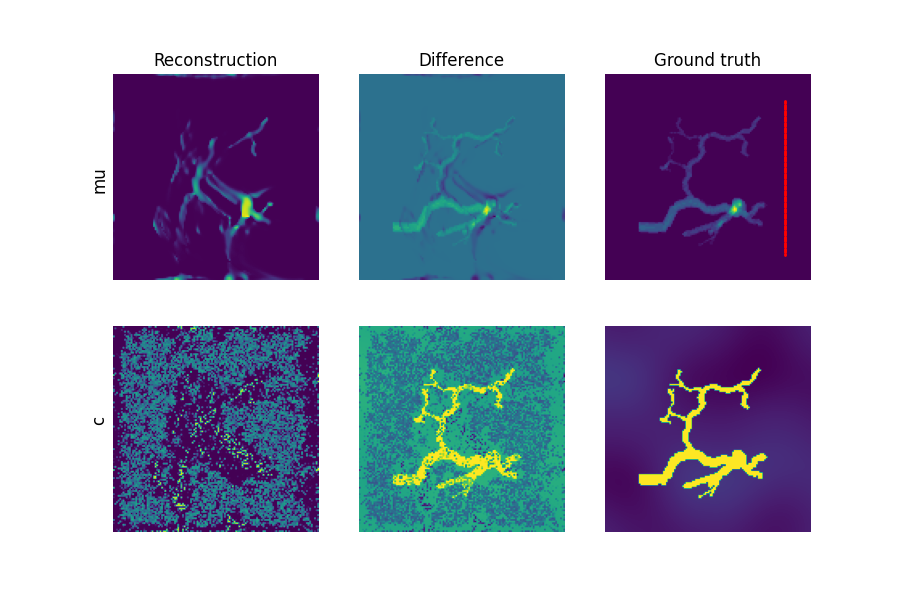

In [3]:
# Save reconstruction images with difference

fig, ax1 = plt.subplots(2, 3, figsize=(9, 6))


ax1[0][0].imshow(mu_r, aspect='equal')
ax1[0][1].imshow(mu - mu_r, aspect='equal')
ax1[0][2].scatter(sensors[1], sensors[0], c='r', s=1)
ax1[0][2].imshow(mu, aspect='equal')
ax1[1][0].imshow(c_r, aspect='equal')
ax1[1][1].imshow(c - c_r, aspect='equal')
ax1[1][2].imshow(c, aspect='equal')

#turn off all axis
for ax in ax1.flatten():
    ax.axis('off')

fig.text(0.11, 0.7, 'mu', va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(0.11, 0.3, 'c', va='center', ha='center', rotation='vertical', fontsize=12)

ax1[0][0].set_title('Reconstruction')
ax1[0][1].set_title('Difference')
ax1[0][2].set_title('Ground truth')

fig.savefig('../../Report/figures/recon_trained_2_P0.pdf', bbox_inches='tight', format='pdf')

In [7]:
# Typical syntax for a single reconstruction

num_it = 10
num_illum = 4

key, subkey = jax.random.split(key)

losses_batch, recon_batch = r.recon_batch(
    func_recon=r.recon_2opt,
    func_step=r.recon_step,
    file_indices=[0],
    lr=[1.,1.],
    num_illum=num_illum,
    num_it=num_it,
    func_step_kwargs={},
    save=True
)

illumination angles: [  0.  90. 180. 270.]
File 0 
Iter	Loss_data	Loss_mu		Loss_c		Loss_sum_mu_c
0	0.049233	2.294207	0.680063	2.974270
2	0.004648	1.584428	0.674251	2.258679
4	0.000944	1.654477	0.668673	2.323150
6	0.000538	1.716567	0.670525	2.387091
9	0.000396	1.806191	0.674225	2.480417


---

# Parameterizations
## Softplus

Array(0., dtype=float32, weak_type=True)

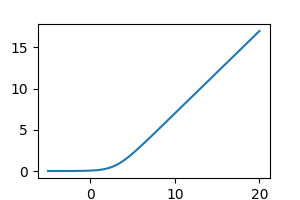

In [9]:
xs = jnp.linspace(-5, 20, 120)
def get_mu(params):
    return compose(params-3)(nn.softplus)
fig, ax = plt.subplots(figsize=(3, 2))
plt.plot(xs, get_mu(xs))
plt.savefig('../../Report/figures/softplus.pdf', bbox_inches='tight', format='pdf')
get_mu(-990000)

## Sigmoid

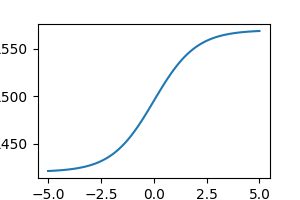

In [10]:
xs = jnp.linspace(-5, 5, 120)

def get_sound_speed(params):
    return 1420.0 + 150.0*compose(params)(nn.sigmoid)
fig, ax = plt.subplots(figsize=(3, 2))
plt.plot(xs,get_sound_speed(xs))
plt.savefig('../../Report/figures/sigmoid.pdf', bbox_inches='tight', format='pdf')
# plt.plot(xs,1410 + 150 * compose(xs)(nn.sigmoid))

In [41]:
import jax
import jax.numpy as jnp
from jax import grad

# Define the get_sound_speed function
def get_sound_speed(params):
    return 1420.0 + 150.0 * jax.nn.sigmoid(params)

# Target value
target_value = u.C  # Replace with your specific value

# Define the function we want to solve for: get_sound_speed(x) - target_value = 0
def equation_to_solve(params):
    return get_sound_speed(params) - target_value

# Gradient of the function to solve
equation_grad = grad(equation_to_solve)

# Fixed-point iteration to find the root
def solve_for_x(target_value, initial_guess=0.0, max_iter=1000, tol=1e-6):
    x = initial_guess
    for i in range(max_iter):
        # Update using a simple iteration method, for example, Newton-Raphson:
        f_x = equation_to_solve(x)
        f_prime_x = equation_grad(x)

        if jnp.abs(f_x) < tol:
            print(f"Converged in {i} iterations")
            return x
        
        x = x - f_x / f_prime_x  # Newton-Raphson update
        
    print("Did not converge within the maximum number of iterations")
    return x

# Example usage:
initial_guess = 0.0  # Initial guess for the parameter
x_solution = solve_for_x(target_value, initial_guess)

print(f"Solved x: {x_solution}")
print(f"Corresponding sound speed: {get_sound_speed(x_solution)}")


Converged in 4 iterations
Solved x: -1.3862953186035156
Corresponding sound speed: 1450.0
